**Initial Setup**

In [ ]:
import os
import zipfile
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
zip_path = '/content/facades-20250618T120104Z-1-001.zip'  # Uploaded path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/facades')
print("✅ Dataset extracted to /content/facades")


✅ Dataset extracted to /content/facades


**Load and Visualize Paired Image Dataset**

In [ ]:
class PairedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        input_img = img.crop((0, 0, w // 2, h))
        target_img = img.crop((w // 2, 0, w, h))
        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)
        return input_img, target_img


In [ ]:
!ls /content/facades
!ls /content/facades/*

facades
test  train  val


**Define transforms and create dataset**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),                  # Converts [0,255] to [0,1]
    transforms.Normalize((0.5, 0.5, 0.5),   # Then to [-1,1]
                         (0.5, 0.5, 0.5))
])


**Define the Generator (U-Net Architecture)**

In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        def down(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up(in_c, out_c, dropout=0.0):
            layers = [
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        # Encoder
        self.down1 = down(in_channels, 64, normalize=False)
        self.down2 = down(64, 128)
        self.down3 = down(128, 256)
        self.down4 = down(256, 512)
        self.down5 = down(512, 512)
        self.down6 = down(512, 512)
        self.down7 = down(512, 512)
        self.down8 = down(512, 512, normalize=False)

        # Decoder
        self.up1 = up(512, 512, dropout=0.5)
        self.up2 = up(1024, 512, dropout=0.5)
        self.up3 = up(1024, 512, dropout=0.5)
        self.up4 = up(1024, 512)
        self.up5 = up(1024, 256)
        self.up6 = up(512, 128)
        self.up7 = up(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))

        return self.final(torch.cat([u7, d1], 1))


**Define the Discriminator (PatchGAN)**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def block(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels * 2, 64, normalize=False),  # input + target
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        # Concatenate input and output images
        return self.model(torch.cat([x, y], 1))


**Device Setup and Model Instantiation**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)


**Loss Functions and Optimizers**

In [ ]:
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


**Training Loop**

In [ ]:
epochs = 5
for epoch in range(epochs):
    for i, (input_img, target_img) in enumerate(dataloader):
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        fake_img = generator(input_img)

        real_validity = discriminator(input_img, target_img)
        fake_validity = discriminator(input_img, fake_img.detach())

        real_labels = torch.ones_like(real_validity).to(device)
        fake_labels = torch.zeros_like(fake_validity).to(device)

        d_loss_real = adversarial_loss(real_validity, real_labels)
        d_loss_fake = adversarial_loss(fake_validity, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # -----------------
        #  Train Generator
        # -----------------
        fake_validity = discriminator(input_img, fake_img)
        g_adv_loss = adversarial_loss(fake_validity, real_labels)
        g_l1_loss = l1_loss(fake_img, target_img)
        g_loss = g_adv_loss + 100 * g_l1_loss  # 100 is L1 loss weight

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Logging
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(dataloader)}] "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch [1/5] Batch [0/400] D Loss: 0.7093, G Loss: 84.1621
Epoch [1/5] Batch [100/400] D Loss: 0.0101, G Loss: 45.4470
Epoch [1/5] Batch [200/400] D Loss: 0.3369, G Loss: 29.3875
Epoch [1/5] Batch [300/400] D Loss: 0.1891, G Loss: 47.0023
Epoch [2/5] Batch [0/400] D Loss: 0.0920, G Loss: 38.1852
Epoch [2/5] Batch [100/400] D Loss: 0.0468, G Loss: 53.0967
Epoch [2/5] Batch [200/400] D Loss: 0.7086, G Loss: 33.6293
Epoch [2/5] Batch [300/400] D Loss: 0.0380, G Loss: 42.0584
Epoch [3/5] Batch [0/400] D Loss: 0.0326, G Loss: 44.1643
Epoch [3/5] Batch [100/400] D Loss: 0.6728, G Loss: 61.3916
Epoch [3/5] Batch [200/400] D Loss: 0.1994, G Loss: 29.8319
Epoch [3/5] Batch [300/400] D Loss: 0.2665, G Loss: 46.8679
Epoch [4/5] Batch [0/400] D Loss: 0.1708, G Loss: 31.4525
Epoch [4/5] Batch [100/400] D Loss: 0.1476, G Loss: 52.6711
Epoch [4/5] Batch [200/400] D Loss: 0.8295, G Loss: 31.9320
Epoch [4/5] Batch [300/400] D Loss: 0.0404, G Loss: 42.8016
Epoch [5/5] Batch [0/400] D Loss: 0.1729, G Loss

In [ ]:
# Examine the extracted directory structure to find an image file
!ls /content/facades/facades/train | head

100.jpg
101.jpg
102.jpg
103.jpg
104.jpg
105.jpg
106.jpg
107.jpg
108.jpg
109.jpg


**Save and Display Output Automatically**

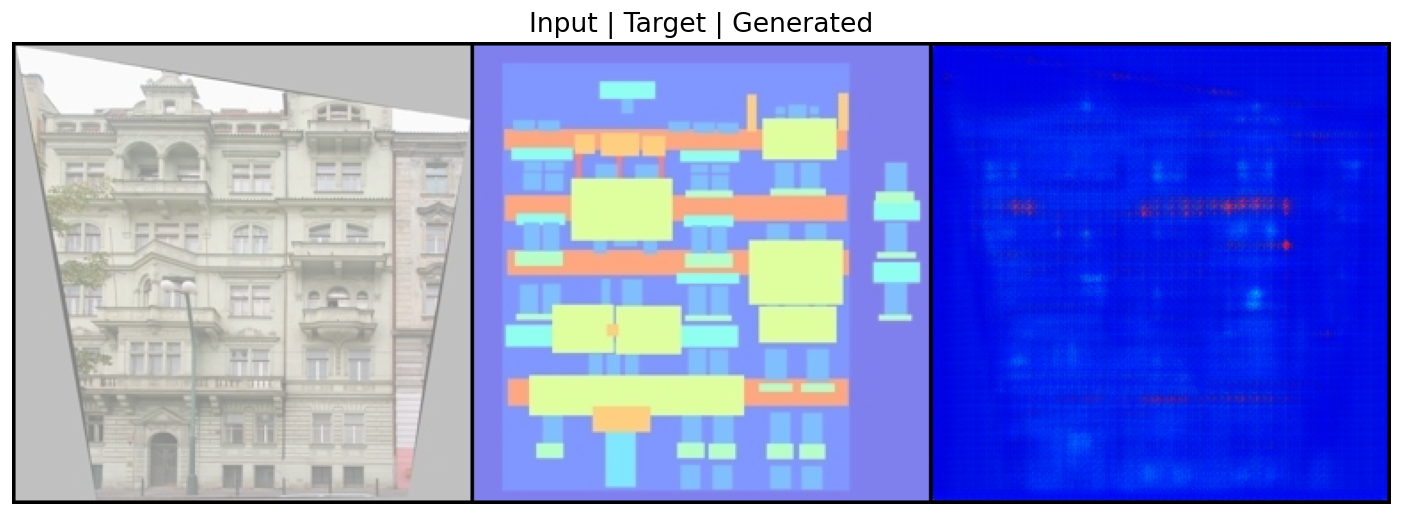

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Denormalize from [-1, 1] to [0, 1]
def denorm(tensor):
    return torch.clamp(tensor * 0.5 + 0.5, 0, 1)

# Denormalize and squeeze if needed
input_img = denorm(input_img.squeeze())
target_img = denorm(target_img.squeeze())
fake_img = denorm(fake_img.squeeze())

# Create a grid: Input | Target | Generated
grid = make_grid([input_img, target_img, fake_img], nrow=3)

# Display the images
plt.figure(figsize=(15, 5), dpi=120)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Input | Target | Generated", fontsize=16)
plt.axis("off")
plt.show()
